In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os
from pathlib import Path
from sklearn.model_selection import train_test_split
import shutil

#Diretório base dos dados
dir_base = Path('/content/drive/My Drive/FotosIA')

#Nome das classes dentro do dataset
classes = ['Céu', 'Comida']

#Cria diretórios para treino, validação e teste dentro da pasta FotosIA
for i in ['train', 'val', 'test']:
    for cls in classes:
        os.makedirs(dir_base / i / cls, exist_ok=True)

In [3]:
#Função para dividir os dados
def divide_dados(dir_src, dir_dest, split_ratio):
    #Lista todas as imagens no diretório de origem
    arquivos = [f for f in os.listdir(dir_src) if f.lower().endswith(('jpg', 'jpeg', 'png', 'ppm', 'bmp', 'pgm', 'tif', 'tiff', 'webp'))]
    #Divide os arquivos em conjuntos de treino e validação/teste
    arquivos_treino, arquivos_val_teste = train_test_split(arquivos, test_size = split_ratio[1] + split_ratio[2])
    #Divide o conjunto de validação/teste em conjuntos de validação e teste
    val_files, test_files = train_test_split(arquivos_val_teste, test_size = split_ratio[2] / (split_ratio[1] + split_ratio[2]))

    #Copia os conjuntos de arquivos para seus respectivos diretórios
    for file in arquivos_treino:
        shutil.copy(dir_src / file, dir_dest / 'train' / dir_src.name / file)
    for file in val_files:
        shutil.copy(dir_src / file, dir_dest / 'val' / dir_src.name / file)
    for file in test_files:
        shutil.copy(dir_src / file, dir_dest / 'test' / dir_src.name / file)

In [4]:
#Divide os dados (70% para treino, 15% para validação e 15% para teste)
split_ratio = [0.7, 0.15, 0.15]
for cls in classes:
    divide_dados(dir_base / cls, dir_base, split_ratio)

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms

#Transformações/Nomralizações de dados

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [6]:
#Diretório inicial dos dados
data_dir = '/content/drive/My Drive/FotosIA'
#Cria o datasets de imagens e aplica as transformações nas imagens
imagem_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val', 'test']}
#Cria dataloaders para carregar os dados em mini-batchs durante o treinamento
dataloaders = {x: torch.utils.data.DataLoader(imagem_datasets[x], batch_size=32, shuffle=True, num_workers=2) for x in ['train', 'val', 'test']}
#Calcula os tamanhos dos datasets
dataset_sizes = {x: len(imagem_datasets[x]) for x in ['train', 'val', 'test']}
#Obtém os nomes das classes
class_names = imagem_datasets['train'].classes

In [7]:
#Usará a GPU se disponível, caso contrário, usará a CPU para as execuções
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [8]:
#Função para treinar os modelos

def train_model(model, criterion, optimizer, num_epochs=25):
    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        print()

    return model

In [9]:
#Carrega o modelo pré-treinado AlexNet e modifica a última camada (Finetuning)

alexnet = models.alexnet(pretrained=True)
num_ftrs = alexnet.classifier[6].in_features
alexnet.classifier[6] = nn.Linear(num_ftrs, len(class_names))
alexnet = alexnet.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(alexnet.parameters(), lr=0.001, momentum=0.9)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [10]:
alexnet

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [11]:
#Treina o modelo AlexNet
alexnet = train_model(alexnet, criterion, optimizer, num_epochs=5)

Epoch 0/4
----------
train Loss: 0.2316 Acc: 0.9211
val Loss: 0.0173 Acc: 1.0000

Epoch 1/4
----------
train Loss: 0.0489 Acc: 0.9847
val Loss: 0.0158 Acc: 0.9936

Epoch 2/4
----------
train Loss: 0.0336 Acc: 0.9822
val Loss: 0.0039 Acc: 1.0000

Epoch 3/4
----------
train Loss: 0.0261 Acc: 0.9898
val Loss: 0.0022 Acc: 1.0000

Epoch 4/4
----------
train Loss: 0.0226 Acc: 0.9924
val Loss: 0.0036 Acc: 1.0000



In [12]:
#Salva o modelo AlexNet no google drive
alexnet_dir = '/content/drive/My Drive/FotosIA/AlexNet.pth'
torch.save(alexnet.state_dict(), alexnet_dir)

In [13]:
#Carrega o modelo pré-treinado Densenet169 e modifica a última camada (Finetuning)

densenet = models.densenet169(pretrained=True)
num_ftrs = densenet.classifier.in_features
densenet.fc = nn.Linear(num_ftrs, len(class_names))
densenet = densenet.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(densenet.parameters(), lr=0.001, momentum=0.9)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet169_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet169_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [14]:
densenet

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [15]:
#Treina o modelo densenet
densenet = train_model(densenet, criterion, optimizer, num_epochs=5)

Epoch 0/4
----------
train Loss: 5.0922 Acc: 0.3282
val Loss: 0.3293 Acc: 0.9172

Epoch 1/4
----------
train Loss: 0.1061 Acc: 0.9720
val Loss: 0.0136 Acc: 1.0000

Epoch 2/4
----------
train Loss: 0.0749 Acc: 0.9873
val Loss: 0.0063 Acc: 1.0000

Epoch 3/4
----------
train Loss: 0.0419 Acc: 0.9924
val Loss: 0.0046 Acc: 1.0000

Epoch 4/4
----------
train Loss: 0.0447 Acc: 0.9796
val Loss: 0.0017 Acc: 1.0000



In [16]:
#Salva o modelo Densenet169 no google drive
densenet_dir = '/content/drive/My Drive/FotosIA/DenseNet.pth'
torch.save(densenet.state_dict(),densenet_dir)

In [17]:
from sklearn.metrics import classification_report

#Função para avaliar um modelo treinado no conjunto de dados de teste
def avaliar_modelo(modelo):
    # Set the model to evaluation mode. This disables dropout layers and uses running statistics for batch normalization.
    modelo.eval()

    # Initialize lists to store true labels and predicted labels
    all_labels = []
    all_preds = []

    # Disable gradient calculation to save memory and computations
    with torch.no_grad():
        # Loop over the test dataset
        for inputs, labels in dataloaders['test']:
            # Move inputs and labels to the device (CPU or GPU)
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Get model outputs for the inputs
            outputs = modelo(inputs)
            # Get the predicted class by finding the index of the maximum value in the outputs
            _, preds = torch.max(outputs, 1)

            # Convert the labels and predictions to numpy arrays and add them to the lists
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    # Return the true labels and predicted labels
    return all_labels, all_preds

In [18]:
#Avalia o AlexNet
y_true, y_pred = avaliar_modelo(alexnet)
print("AlexNet Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

AlexNet Classification Report:
              precision    recall  f1-score   support

        Céu       1.00      1.00      1.00        76
      Comida       1.00      1.00      1.00        81

    accuracy                           1.00       157
   macro avg       1.00      1.00      1.00       157
weighted avg       1.00      1.00      1.00       157



In [19]:
#Avalia o Densenet169
y_true, y_pred = avaliar_modelo(densenet)
print("Densenet169 Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

Densenet169 Classification Report:
              precision    recall  f1-score   support

        Céu       1.00      1.00      1.00        76
      Comida       1.00      1.00      1.00        81

    accuracy                           1.00       157
   macro avg       1.00      1.00      1.00       157
weighted avg       1.00      1.00      1.00       157



#Classificaçao de imagem

In [20]:
from PIL import Image
import matplotlib.pyplot as plt

#Função para carregar e pré-processar a imagem
def process_image(image_path):
    image = Image.open(image_path)
    transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    image = transform(image).unsqueeze(0)
    return image

#Função para classificar a imagem usando um dos modelos
def classify_image(model, image_path):
    model.eval()
    image = process_image(image_path)
    image = image.to(device)

    with torch.no_grad():
        outputs = model(image)
        _, preds = torch.max(outputs, 1)
        class_idx = preds.item()
        class_name = class_names[class_idx]

    return class_name

In [21]:
#Caminho da imagem a ser classificada
image_path = '/content/drive/My Drive/FotosIA/testes/teste1.jpeg'

In [22]:
#Classifica a imagem usando AlexNet
class_name_alexnet = classify_image(alexnet, image_path)
print(f'Classificação usando AlexNet: {class_name_alexnet}')

Classificação usando AlexNet: Céu


In [23]:
#Classifica a imagem usando GoogLeNet
class_name_desenet = classify_image(densenet, image_path)
print(f'Classificação usando GoogLeNet: {class_name_desenet}')

Classificação usando GoogLeNet: Céu


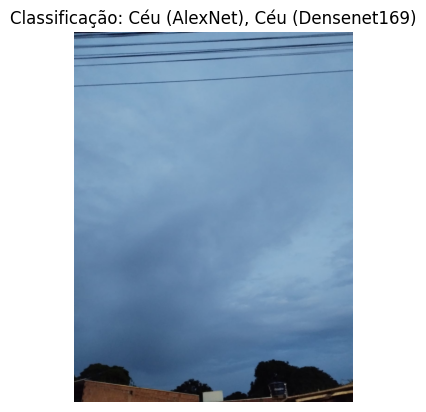

In [24]:
#Exibe a imagem e as classificações dadas pelos dois modelos
image = Image.open(image_path)
plt.imshow(image)
plt.title(f'Classificação: {class_name_alexnet} (AlexNet), {class_name_desenet} (Densenet169)')
plt.axis('off')
plt.show()

TELEGRAM

In [25]:
!pip install torch torchvision python-telegram-bot nest_asyncio

In [26]:
import torch
import torch.nn as nn
from torchvision import models, transforms
from PIL import Image
import io
from telegram import Update
from telegram.ext import ApplicationBuilder, CommandHandler, MessageHandler, filters, ContextTypes
import nest_asyncio
import asyncio

In [27]:
#Permitir reentrância no loop de eventos
nest_asyncio.apply()

In [28]:
#Função para carregar o modelo AlexNet
def carrega_modelo(caminho_do_modelo):
    modelo = models.alexnet(pretrained=True)
    num_ftrs = modelo.classifier[6].in_features
    modelo.classifier[6] = nn.Linear(num_ftrs, 2)
    modelo.load_state_dict(torch.load(caminho_do_modelo, map_location=torch.device('cpu')))
    modelo.eval()
    return modelo

In [29]:
#Caminho para o modelo treinado
caminho_do_modelo = '/content/drive/My Drive/FotosIA/AlexNet.pth'
modelo = carrega_modelo(caminho_do_modelo)

#Transformações de imagem
transforma = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

class_names = ['Céu', 'Comida']

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
<ipython-input-28-1fff4146fad4>:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details)

In [30]:
#Função para classificar a imagem
def classifica_imagem(imagem):
    imagem = transforma(imagem).unsqueeze(0)
    with torch.no_grad():
        outputs = modelo(imagem)
        _, preds = torch.max(outputs, 1)
        class_idx = preds.item()
        class_name = class_names[class_idx]
    return class_name

#Função para responder ao comando /start
async def start(update: Update, context: ContextTypes.DEFAULT_TYPE) -> None:
    await update.message.reply_text('Olá! Envie-me uma foto do Céu ou uma comida para que eu possa classificá-la.')

#Função para responder a fotos enviadas
async def handle_photo(update: Update, context: ContextTypes.DEFAULT_TYPE) -> None:
    photo_file = await update.message.photo[-1].get_file()
    photo_bytes = await photo_file.download_as_bytearray()
    imagem = Image.open(io.BytesIO(photo_bytes))
    class_name = classifica_imagem(imagem)
    await update.message.reply_text(f'Eu acho que isso é um(a) {class_name}')


In [31]:
#Função para configurar o bot
async def main():
    application = ApplicationBuilder().token("7239221335:AAFP7bbLzO8NXco1lqKi8CdQyzYoF3wsS4k").build()

    application.add_handler(CommandHandler("start", start))
    application.add_handler(MessageHandler(filters.PHOTO, handle_photo))

    await application.run_polling()

In [33]:
#Executa o bot
await main()

RuntimeError: Cannot close a running event loop